# Goal

- Link Prediction that predicts future links between facebook pages

### Dataset

- The dataset provides us with target and edges which are both csv files.

- For edges, the features, id_1 and id_2 represent the nodes that will form the graph. The nodes are the values of the features

- Nodes in one row of the dataframe represent links. An example will be shown down below

### Independent and Dependent Variables

We are given a dataset that gives us nodes and each node represents facebook pages. One row of nodes (a pair of nodes) represents a link.

- Target variable: page_type is the target variable

- Features/Independent variable: node_link and page_name. Implementing another relevant feature can improve the accuracy of our model

# Imports

In [1]:
import pandas as pd
import numpy as np

import json

# NLP
import re
import string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import texthero as hero

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import keras
import tensorflow
import torch
import torchvision
import networkx as nx

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zakijefferson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


# Data

In [2]:
target_df = pd.read_csv("Data/musae_facebook_target.csv")
edges_df = pd.read_csv("Data/musae_facebook_edges.csv")

In [3]:
# Reading the json as a dict
with open("Data/musae_facebook_features.json") as json_data:
    feature_data_dict = json.load(json_data)
    
features_df = pd.DataFrame.from_dict(feature_data_dict, orient="index")

# Exploratory Data Analysis

In [4]:
print(f"[INFO] This shows the rows and columns of the target dataframe:\nRows: {target_df.shape[0]}\nColumns: {target_df.shape[1]}")
print("-"*60)
print(f"[INFO] This shows the rows and columns of the edges dataframe:\nRows: {edges_df.shape[0]}\nColumns: {edges_df.shape[1]}")

[INFO] This shows the rows and columns of the target dataframe:
Rows: 22470
Columns: 4
------------------------------------------------------------
[INFO] This shows the rows and columns of the edges dataframe:
Rows: 171002
Columns: 2


In [5]:
# Contains the target variables
target_df.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [6]:
# Looking for duplicates
target_df.duplicated().sum()

0

In [7]:
# The edges (id_1 and id_2) represents the nodes that will form the graph
# Nodes in one row of the data frame represent links
edges_df.head()

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [8]:
# Looking for duplicates
edges_df.duplicated().sum()

0

### Node Explanation/Data Explanation

We are using an iloc function to access the rows and columns of the edges dataframe. 

The iloc function below is grabbing node 0 which has a page name/represents The Voice of China in the category/page_type tvshow is connected to node 18427 The Voice Global. This is one link

i.e. node 0, which represents The Voice of China is connected to node 18427, which represents The Voice Global, and both are in the tvshow category. This is all one link.

The page types will also be connected to other pages to form a network.

In [9]:
target_df.iloc[edges_df["id_1"][0]], target_df.iloc[edges_df["id_2"][0]]

(id                                    0
 facebook_id             145647315578475
 page_name      The Voice of China 中国好声音
 page_type                        tvshow
 Name: 0, dtype: object,
 id                        18427
 facebook_id    1563883503866518
 page_name      The Voice Global
 page_type                tvshow
 Name: 18427, dtype: object)

### Node Explanation/Data Explanation

The code below shows node 1 represenets U.S. Consulate General Mumbai and node 21708 represents U.S. Department of State: Bureau of Intl Narco... and both nodes are in the government category. This is one link.

In [10]:
target_df.iloc[edges_df["id_1"][1]], target_df.iloc[edges_df["id_2"][1]]

(id                                         1
 facebook_id                     191483281412
 page_name      U.S. Consulate General Mumbai
 page_type                         government
 Name: 1, dtype: object,
 id                                                         21708
 facebook_id                                         367067283779
 page_name      U.S. Department of State: Bureau of Intl Narco...
 page_type                                             government
 Name: 21708, dtype: object)

# Data Type Expl

# Univariate Analysis

/Users/zakijefferson/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


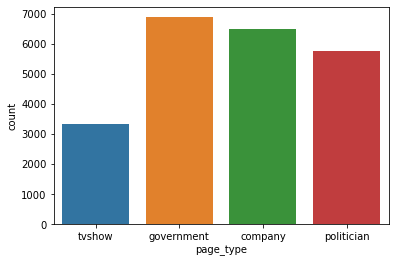

In [11]:
sns.countplot(target_df["page_type"])
plt.show()

# Multivariate Analysis

Graphing the nodes and links

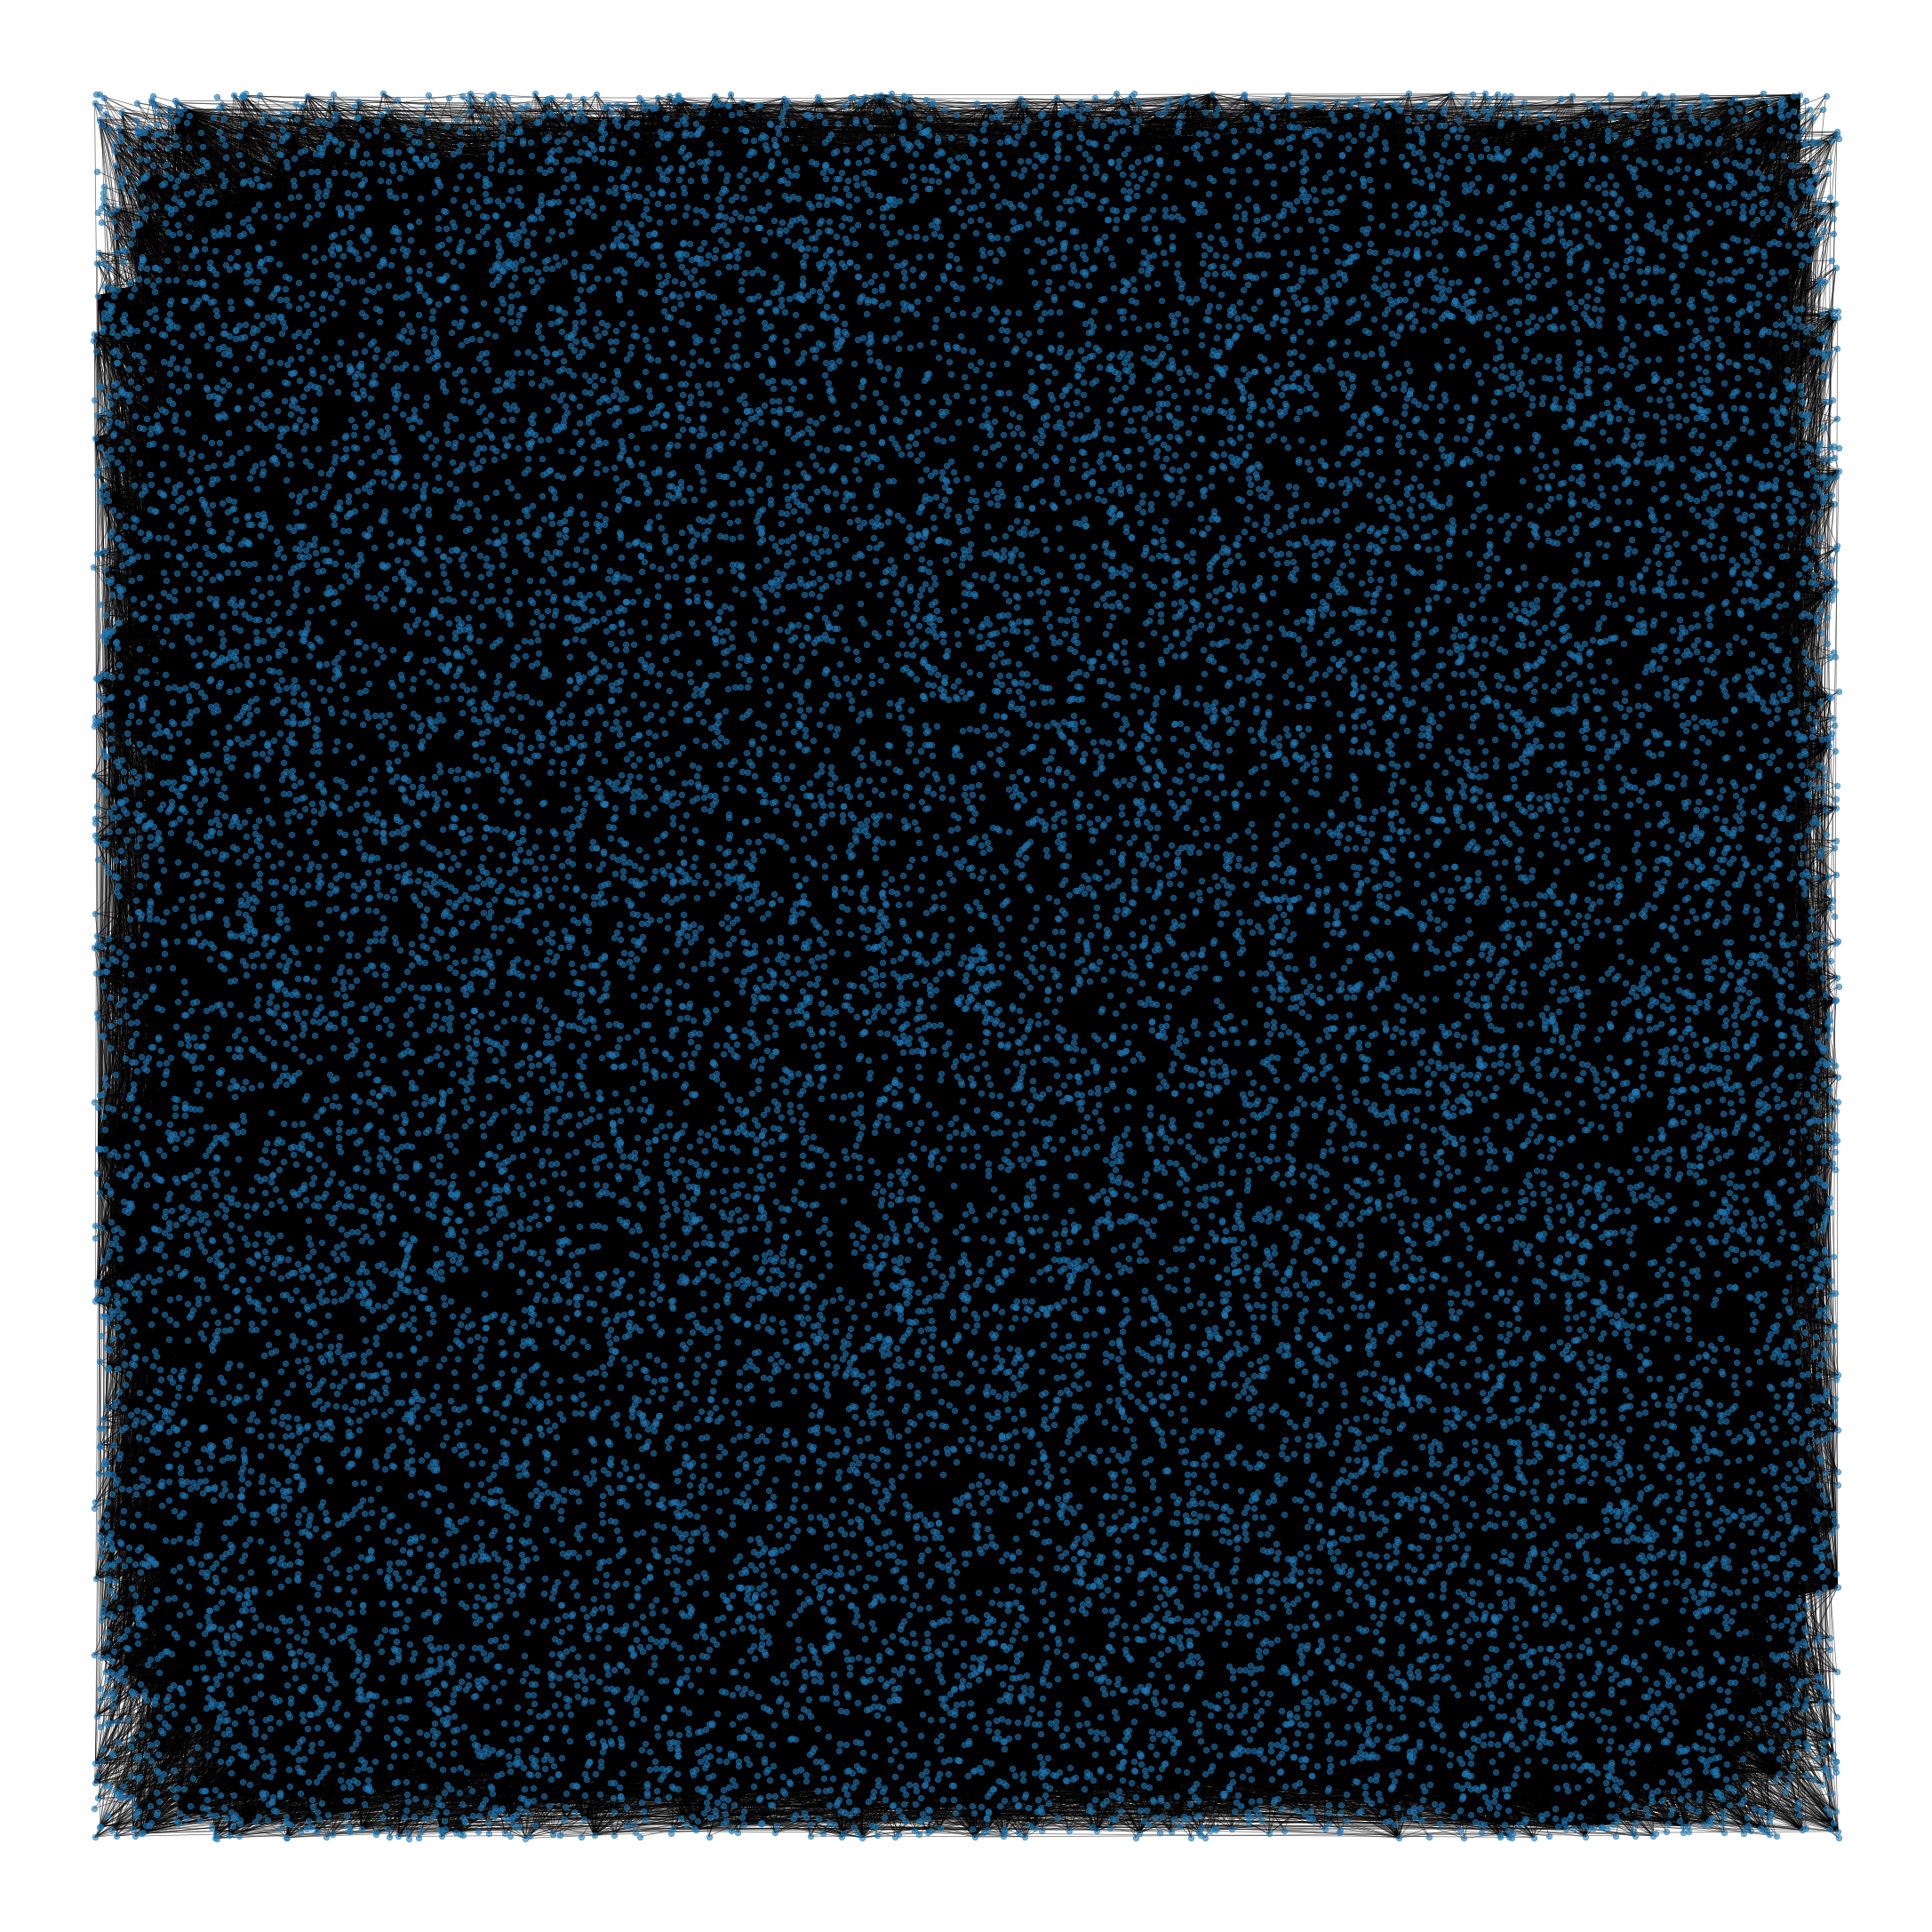

In [12]:
# create graph
G = nx.from_pandas_edgelist(edges_df, "id_1", "id_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(30, 30))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

# Cleaning Data

1. Add a new column to edges dataframe called node_links and rename columns

2. Combine data on index and remove redundant feautures

3. Remove missing values

4. Econding

5. Tokenization

6. Vectorization

1. Add new column to edges dataframe called node_links and rename columns and converting

In [3]:
edges_df["node_link"] = list(zip(edges_df["id_1"], edges_df["id_2"]))

In [4]:
# Renaming id_1 and id_2 to node_1 and node_2
edges_df.rename(columns={"id_1": "node_1", "id_2": "node_2"}, inplace=True)

In [5]:
edges_df.head()

,node_1,node_2,node_link
0,0,18427,"(0, 18427)"
1,1,21708,"(1, 21708)"
2,1,22208,"(1, 22208)"
3,1,22171,"(1, 22171)"
4,1,6829,"(1, 6829)"


2. Combine data on index and remove redundant features

In [6]:
# Merging dataframes on index
df = pd.merge(target_df[["page_name", "page_type"]], edges_df[["node_link"]], left_index=True, right_index=True)

print(f"[INFO] The Number of rows and columns will be shown below\nRow: {df.shape[0]}\nColumn: {df.shape[1]}")
df.head()

[INFO] The Number of rows and columns will be shown below
Row: 22470
Column: 3


,page_name,page_type,node_link
0,The Voice of China 中国好声音,tvshow,"(0, 18427)"
1,U.S. Consulate General Mumbai,government,"(1, 21708)"
2,ESET,company,"(1, 22208)"
3,Consulate General of Switzerland in Montreal,government,"(1, 22171)"
4,Mark Bailey MP - Labor for Miller,politician,"(1, 6829)"


3. Remove missing values

In [7]:
# Looking for missing values
df.isna().sum()

page_name    0
page_type    0
node_link    0
dtype: int64

4. Encoding

In [8]:
# Instantiating LabelEncoder
label_encode = LabelEncoder()

In [9]:
print(f"[INFO] Unique values of page_type: {df.page_type.unique()}")
# Label encoding page type
df["page_type"] = label_encode.fit_transform(df["page_type"])

print(f"[INFO] Classes of the label encoded values: {df.page_type.unique()} = {label_encode.classes_}")

[INFO] Unique values of page_type: ['tvshow' 'government' 'company' 'politician']
[INFO] Classes of the label encoded values: [3 1 0 2] = ['company' 'government' 'politician' 'tvshow']


5. Tokenization

In [10]:
# Cleaning text data before tokenization
def clean_text(df, column:str):
    """Make text lowercase, 
    remove square brackers,
    and remove punctuations"""
    df[column] = [names.lower() for names in df[column]]  # Convert all letter to lowercase
    df[column] = [names.encode("ascii", errors="ignore").decode() for names in df[column]] # Remove non ascii chars
    df[column] = [re.sub("\[.*?\]", "", names) for names in df[column]]  # Remove anything in brackets
    df[column] = [re.sub("[%s]" % re.escape(string.punctuation), "", names) for names in df[column]]  # Remove punctuations
    df[column] = [re.sub("\w*\d\w*", "", names) for names in df[column]]  # Remove words with numbers in them
    df[column] = [re.sub(r"^\s+", "", names) for names in df[column]]  # Remove only whitespaces
    return df[column]

In [11]:
clean_text(df, "page_name")

0                                 the voice of china 
1                         us consulate general mumbai
2                                                eset
3        consulate general of switzerland in montreal
4                    mark bailey mp  labor for miller
                             ...                     
22465                                 kurt wiegel mdl
22466                                  dubdub stories
22467               ministerio del interior  paraguay
22468                                      tottus per
22469                                      doppelpass
Name: page_name, Length: 22470, dtype: object

Tokenization takes place

In [12]:
# Tokenizing the page_name feature
# df["page_name"] = [nltk.word_tokenize(words) for words in df["page_name"]]
df["page_name"] = [hero.tokenize(words) for words in df["page_name"]]

In [13]:
# Removing stop words
# df["page_name"] = df["page_name"].apply(lambda x: [item for item in x if item not in nltk.corpus.stopwords.words("english")])
df["page_name"] = df["page_name"].apply(lambda x: hero.remove_stopwords(x))

In [14]:
# Dropping empty strings by index. The empty strings represents foreign languages
foreign_lang_index = df.loc[df["page_name"] == ""].index
df.drop(index=foreign_lang_index, inplace=True)

# Dropping empty list
empty_list_index = df.loc[df["page_name"].str.len() == 0].index
df.drop(index=empty_list_index, inplace=True)

Converiting node_link from a Series to a list of arrays

In [15]:
# Changing node_link to a list of arrays
df["node_link"] = df["node_link"].apply(lambda x: list(x))

6. Vectorization

In [16]:
df["page_name"] = df["page_name"].to_string()

In [17]:
# Using herotext tfidf to put text into numeric value of how important a token is
df["page_name"] = hero.tfidf(df["page_name"])

In [18]:
df.head()

,page_name,page_type,node_link
0,"[0.07548456442375773, 0.0006038765153900618, 0...",3,"[0, 18427]"
1,"[0.07548456442375773, 0.0006038765153900618, 0...",1,"[1, 21708]"
2,"[0.07548456442375773, 0.0006038765153900618, 0...",0,"[1, 22208]"
3,"[0.07548456442375773, 0.0006038765153900618, 0...",1,"[1, 22171]"
4,"[0.07548456442375773, 0.0006038765153900618, 0...",2,"[1, 6829]"


In [27]:
df["page_name"] = df["page_name"].apply(lambda x: np.array(x))

# Train, Test, and Validation Split

In [30]:
# Setting Independent and Dependent Variables
X = df.drop(columns="page_type")
y = df["page_type"]

In [31]:
# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

In [226]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape  # Our Train and Test are a 2D Array

((13100, 2), (4367, 2), (13100,), (4367,))

In [238]:
X_train.ndim, y_train.ndim

(2, 1)

In [289]:
X_train

,page_name,node_link
10826,"[0.07548456442375773, 0.0006038765153900618, 0...","[701, 13264]"
9724,"[0.07548456442375773, 0.0006038765153900618, 0...","[613, 1594]"
10772,"[0.07548456442375773, 0.0006038765153900618, 0...","[696, 10747]"
6502,"[0.07548456442375773, 0.0006038765153900618, 0...","[391, 2594]"
16085,"[0.07548456442375773, 0.0006038765153900618, 0...","[1020, 5524]"
...,...,...
3669,"[0.07548456442375773, 0.0006038765153900618, 0...","[222, 15098]"
6356,"[0.07548456442375773, 0.0006038765153900618, 0...","[377, 16508]"
11755,"[0.07548456442375773, 0.0006038765153900618, 0...","[730, 12648]"
19020,"[0.07548456442375773, 0.0006038765153900618, 0...","[1218, 19966]"


In [411]:
X_train_reshape = np.expand_dims(X_train, axis=X_train.ndim)

In [412]:
X_train_reshape.shape

(13100, 2, 1)

In [429]:
X_train_rere = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)

In [430]:
X_train_rere.shape

(13100, 2, 1)

# Nueral Network (LSTM Neural Network)

### Imports

In [366]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, ConvLSTM2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import AveragePooling1D, AveragePooling2D, AveragePooling3D

In [414]:
X_train.shape[0]

13100

In [447]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape), activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(32, activation="sigmoid"))

model.add(LSTM(32, return_sequences=True, activation="sigmoid"))
model.add(Dropout(0.3))

model.add(Dense(16, activation="sigmoid"))

model.add(LSTM(8, return_sequences=True, activation="sigmoid"))
model.add(Dropout(0.3))

model.add(Dense(8, activation="sigmoid"))
model.add(Dense(4, activation="softmax"))

model.summary()

Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_309 (LSTM)              (None, 13100, 64)         17152     
_________________________________________________________________
dropout_182 (Dropout)        (None, 13100, 64)         0         
_________________________________________________________________
dense_498 (Dense)            (None, 13100, 32)         2080      
_________________________________________________________________
lstm_310 (LSTM)              (None, 13100, 32)         8320      
_________________________________________________________________
dropout_183 (Dropout)        (None, 13100, 32)         0         
_________________________________________________________________
dense_499 (Dense)            (None, 13100, 16)         528       
_________________________________________________________________
lstm_311 (LSTM)              (None, 13100, 8)       

In [448]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

print("[INFO] Training neural network...")
# Training 
model.fit(X_train_rere, y_train, epochs=20, batch_size=10, validation_data=(X_val.values, y_val.values), verbose=0)

[INFO] Training neural network...


ValueError: Error when checking input: expected lstm_309_input to have shape (13100, 2) but got array with shape (2, 1)